In [1]:
!pip -q install datasets transformers evaluate accelerate

import os, math, random, numpy as np, torch, torch.nn as nn
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel, DataCollatorWithPadding, get_linear_schedule_with_warmup
import evaluate
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
ds_train = load_dataset("rotten_tomatoes", split="train")
ds_test  = load_dataset("rotten_tomatoes", split="test")

ds_train = ds_train.shuffle(seed=SEED).select(range(4000))
ds_test  = ds_test.shuffle(seed=SEED).select(range(1000))

labels_set = [0,1]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

def tok(batch):
    return tokenizer(batch["text"], truncation=True, max_length=512)

ds_train_tok = ds_train.map(tok, batched=True, remove_columns=["text"])
ds_test_tok  = ds_test.map(tok, batched=True, remove_columns=["text"])

collate = DataCollatorWithPadding(tokenizer=tokenizer, pad_to_multiple_of=8 if torch.cuda.is_available() else None)

train_loader = DataLoader(ds_train_tok, batch_size=16, shuffle=True, collate_fn=collate)
test_loader  = DataLoader(ds_test_tok,  batch_size=32, shuffle=False, collate_fn=collate)

In [4]:
class DistilBertClassifier(nn.Module):
    def __init__(self, model_name="distilbert-base-uncased", num_labels=2):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        hidden = self.encoder.config.dim  # 768
        self.head = nn.Linear(hidden, num_labels)

    def forward(self, input_ids, attention_mask):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        # [CLS] у DistilBERT — это первый токен
        cls = out.last_hidden_state[:,0,:]
        logits = self.head(cls)
        return logits

baseline = DistilBertClassifier(model_name, num_labels=2).to(device)
ndcg_model = DistilBertClassifier(model_name, num_labels=2).to(device)

In [5]:
class NeuralNDCGLoss(nn.Module):
    def __init__(self, tau=3.0, eps=1e-6):
        super().__init__()
        self.tau = tau
        self.eps = eps

    def forward(self, logits, target_idx):
        B, C = logits.shape

        z = (logits - logits.mean(dim=1, keepdim=True)) / (logits.std(dim=1, keepdim=True) + self.eps)

        rel = torch.zeros_like(z)
        rel.scatter_(1, target_idx.view(-1,1), 1.0)  # [B,C]
        s_diff = z.unsqueeze(1) - z.unsqueeze(2)      # [B, C, C] = s_j - s_i
        P = torch.sigmoid(s_diff / self.tau)          # prob "j outranks i"
        eye = torch.eye(C, device=z.device).unsqueeze(0)
        P = P * (1.0 - eye)
        exp_rank = 1.0 + P.sum(dim=1)                 # [B,C]

        # 4) DCG c лог-дисконтами
        discount = 1.0 / torch.log2(1.0 + exp_rank)   # [B,C]
        dcg = (rel * discount).sum(dim=1)             # [B]
        ndcg = dcg
        return -(ndcg.mean())


In [6]:
acc_metric = evaluate.load("accuracy")
f1_metric  = evaluate.load("f1")

@torch.no_grad()
def evaluate_model(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    for batch in loader:
        input_ids = batch["input_ids"].to(device)
        attn = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)   # <-- labels
        logits = model(input_ids, attn)
        preds = logits.argmax(dim=-1)
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())
    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()
    return {
        "accuracy": acc_metric.compute(predictions=all_preds, references=all_labels)["accuracy"],
        "f1": f1_metric.compute(predictions=all_preds, references=all_labels, average="macro")["f1"]
    }

def train_loop(model, loader, epochs=3, lr=2e-5,
               alpha_ndcg_final=0.3, tau=3.0,
               warm_ce_epochs=1,
               max_grad_norm=1.0):
    model.train()
    optim = torch.optim.AdamW(model.parameters(), lr=lr)
    total_steps = epochs * len(loader)
    sched = get_linear_schedule_with_warmup(
        optim,
        num_warmup_steps=int(0.1 * total_steps),
        num_training_steps=total_steps
    )
    ce = nn.CrossEntropyLoss()
    ndcg_loss_fn = NeuralNDCGLoss(tau=tau)

    hist = {"train_loss": [], "eval_acc": [], "eval_f1": []}
    global_step = 0
    for ep in range(1, epochs+1):
        running = 0.0
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attn = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            if ep <= warm_ce_epochs:
                alpha = 0.0
            else:
                progress = (ep - warm_ce_epochs - 1 + (global_step % len(loader))/len(loader)) / max(1, epochs - warm_ce_epochs)
                alpha = alpha_ndcg_final * float(np.clip(progress, 0.0, 1.0))

            logits = model(input_ids, attn)
            loss = ce(logits, labels)
            if alpha > 0.0:
                loss = loss + alpha * ndcg_loss_fn(logits, labels)

            optim.zero_grad()
            loss.backward()
            if max_grad_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optim.step()
            sched.step()
            running += loss.item()
            global_step += 1

        metrics = evaluate_model(model, test_loader)
        hist["train_loss"].append(running/len(loader))
        hist["eval_acc"].append(metrics["accuracy"])
        hist["eval_f1"].append(metrics["f1"])
        print(f"Epoch {ep}: loss={hist['train_loss'][-1]:.4f} | acc={metrics['accuracy']:.4f} | f1={metrics['f1']:.4f} | alpha≈{alpha:.3f}")
    return hist


In [36]:
baseline = DistilBertClassifier(model_name, num_labels=2).to(device)
ndcg_model = DistilBertClassifier(model_name, num_labels=2).to(device)

hist_base = train_loop(baseline, train_loader, epochs=6, lr=1e-6,
                       alpha_ndcg_final=0.0)

hist_ndcg = train_loop(ndcg_model, train_loader, epochs=6, lr=1e-6,
                       alpha_ndcg_final=0.3, tau=3.0, warm_ce_epochs=2)

Epoch 1: loss=0.6917 | acc=0.6190 | f1=0.6131 | alpha≈0.000
Epoch 2: loss=0.6341 | acc=0.7260 | f1=0.7258 | alpha≈0.000
Epoch 3: loss=0.5227 | acc=0.7840 | f1=0.7837 | alpha≈0.000
Epoch 4: loss=0.4452 | acc=0.7960 | f1=0.7955 | alpha≈0.000
Epoch 5: loss=0.4094 | acc=0.8120 | f1=0.8118 | alpha≈0.000
Epoch 6: loss=0.3951 | acc=0.8110 | f1=0.8107 | alpha≈0.000
Epoch 1: loss=0.6729 | acc=0.7190 | f1=0.7183 | alpha≈0.000
Epoch 2: loss=0.5497 | acc=0.7840 | f1=0.7822 | alpha≈0.000
Epoch 3: loss=0.3985 | acc=0.8020 | f1=0.8018 | alpha≈0.075
Epoch 4: loss=0.3027 | acc=0.8110 | f1=0.8110 | alpha≈0.150
Epoch 5: loss=0.2279 | acc=0.8130 | f1=0.8128 | alpha≈0.225
Epoch 6: loss=0.1631 | acc=0.8160 | f1=0.8159 | alpha≈0.300


In [37]:
def plot_history(h1, h2, label1="BASE", label2="+NeuralNDCG"):
    fig, ax = plt.subplots(1,2, figsize=(12,4))

    # train loss
    ax[0].plot(h1["train_loss"], label=f"{label1} train_loss")
    ax[0].plot(h2["train_loss"], label=f"{label2} train_loss")
    ax[0].set_title("Train loss"); ax[0].legend(); ax[0].grid(True)

    # validation / test accuracy (ключ eval_acc!)
    ax[1].plot(h1["eval_acc"], label=f"{label1} eval_acc")
    ax[1].plot(h2["eval_acc"], label=f"{label2} eval_acc")
    ax[1].set_title("Eval accuracy"); ax[1].legend(); ax[1].grid(True)
    plt.show()


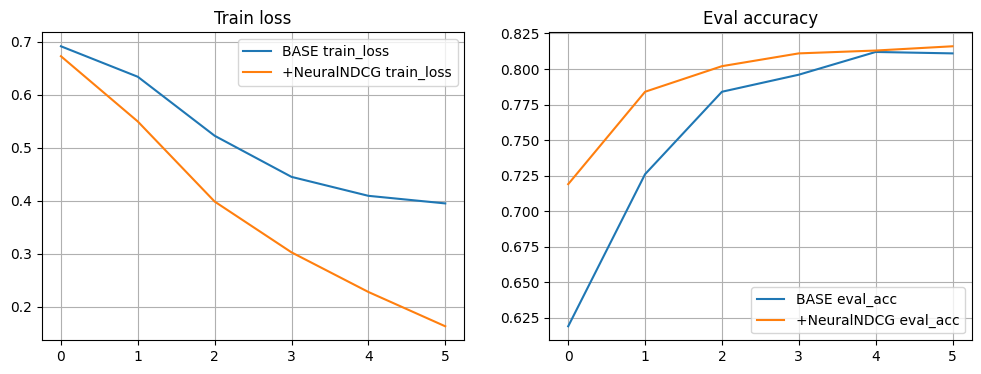

In [38]:
plot_history(hist_base, hist_ndcg)
